In [2]:
from qiskit import QuantumCircuit, Aer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeVigoV2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns
import time
import psutil
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Set seed for random generators
algorithm_globals.random_seed = 42


## Support functions

In [3]:
# Define functions to measure accuracy and resource consumption
def measure_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred, output_dict=True)['accuracy']


def measure_resources():
    cpu = psutil.cpu_percent()
    memory = psutil.virtual_memory().percent
    return cpu, memory  


# Load the data

In [4]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer

# Load data
iris_data = load_iris()
wine_data = load_wine()
breast_cancer_data = load_breast_cancer()


# Process Iris data

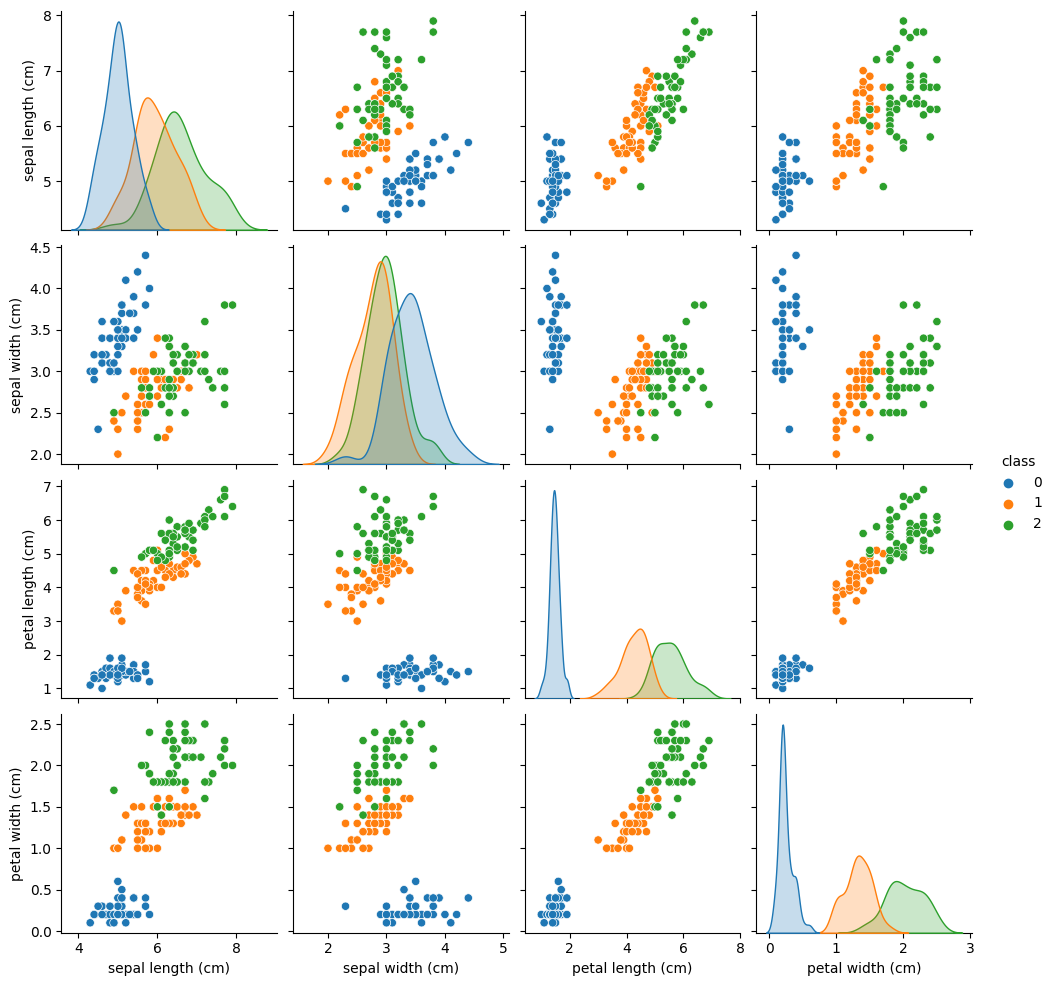

In [5]:
iris_features = iris_data.data
iris_labels = iris_data.target

iris_features = MinMaxScaler().fit_transform(iris_features)

iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df["class"] = pd.Series(iris_data.target)

sns.pairplot(iris_df, hue="class", palette="tab10")


# Process wine data

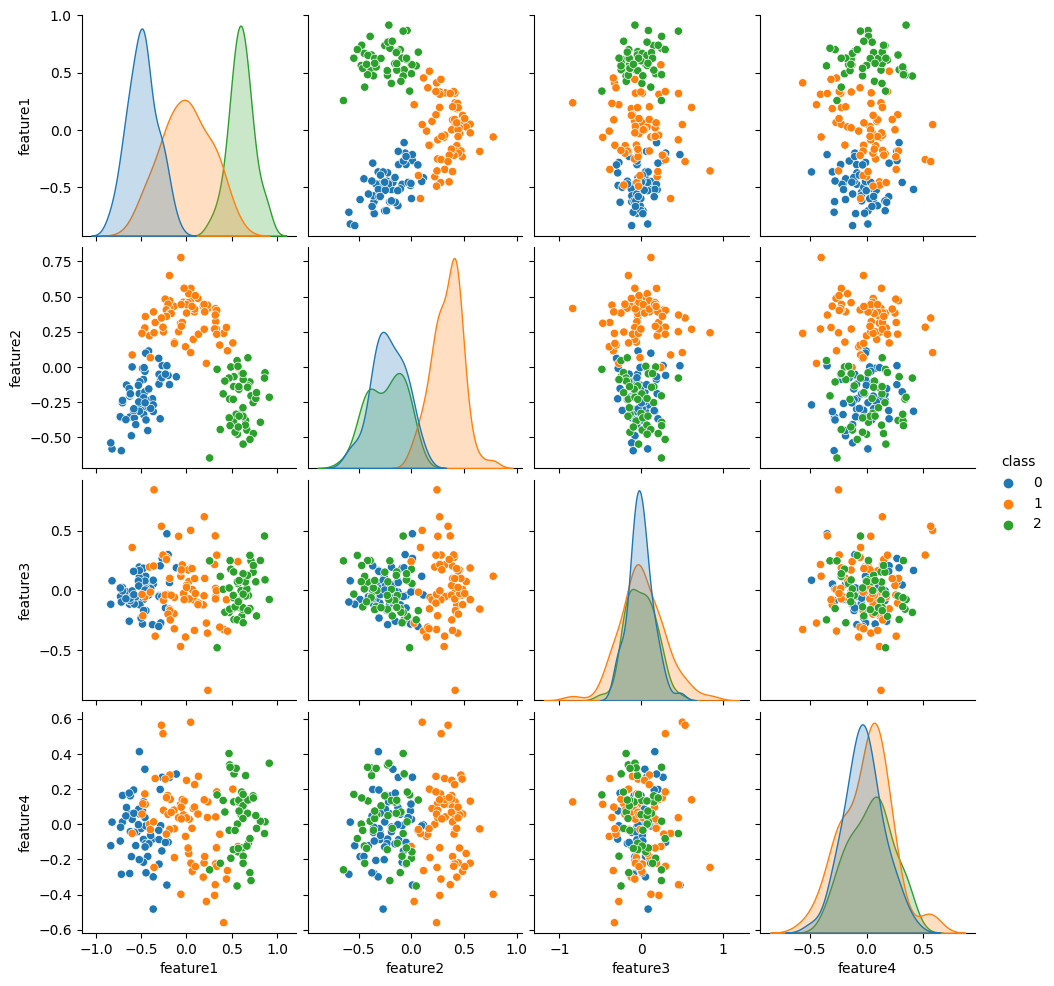

In [6]:
# Limit wine data to 4 features using PCA
wine_features = wine_data.data
wine_labels = wine_data.target

# Apply MinMaxScaler to scale the features
wine_features = MinMaxScaler().fit_transform(wine_features)

# Apply PCA to reduce the number of features to 4
pca = PCA(n_components=4)
wine_features = pca.fit_transform(wine_features)

# Create a DataFrame with the reduced features and class labels
wine_df = pd.DataFrame(wine_features, columns=[
                       'feature1', 'feature2', 'feature3', 'feature4'])
wine_df["class"] = pd.Series(wine_data.target)

# Create a pairplot of the reduced features with class labels as hue
sns.pairplot(wine_df, hue="class", palette="tab10")
plt.show()


# Process breast cancer data

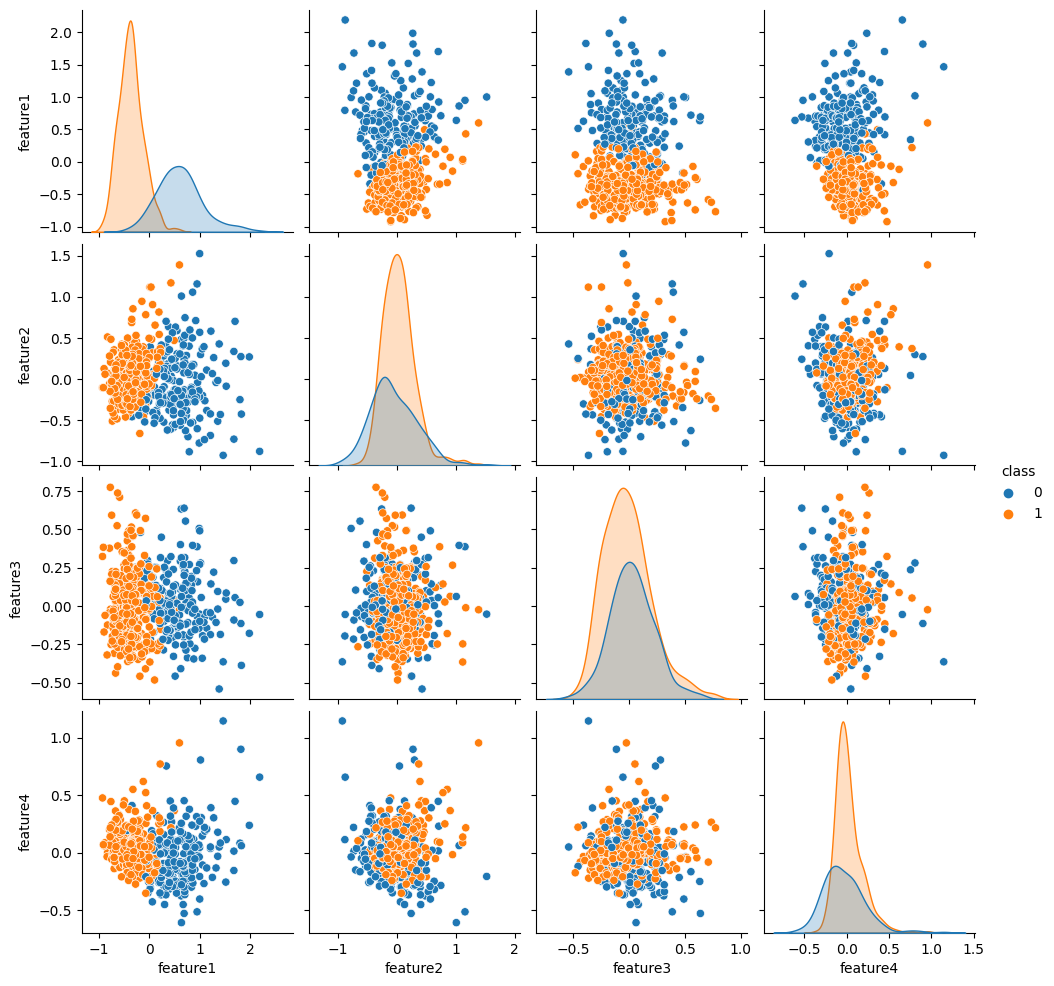

In [7]:
# Limit breast cancer data to 4 features
breast_cancer_features = breast_cancer_data.data
breast_cancer_labels = breast_cancer_data.target

# Apply MinMaxScaler to scale the features
breast_cancer_features = MinMaxScaler().fit_transform(breast_cancer_features)

# Apply PCA to reduce the number of features to 4
pca = PCA(n_components=4)
breast_cancer_features = pca.fit_transform(breast_cancer_features)

# Create a DataFrame with the reduced features and class labels
breast_cancer_df = pd.DataFrame(
    breast_cancer_features, columns=['feature1', 'feature2', 'feature3', 'feature4'])
breast_cancer_df["class"] = pd.Series(breast_cancer_data.target)

# Create a pairplot of the reduced features with class labels as hue
sns.pairplot(breast_cancer_df, hue="class", palette="tab10")
plt.show()


In [8]:
# Split iris data
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    iris_features, iris_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


In [9]:
# Split wine data
train_features_wine, test_features_wine, train_labels_wine, test_labels_wine = train_test_split(
    wine_features, wine_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [10]:
# Split breast cancer data
train_features_breast_cancer, test_features_breast_cancer, train_labels_breast_cancer, test_labels_breast_cancer = train_test_split(
    breast_cancer_features, breast_cancer_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

# Setup Simulation

In [11]:
sim = Aer.get_backend('qasm_simulator')
shots = 20000

# Iris Classifier

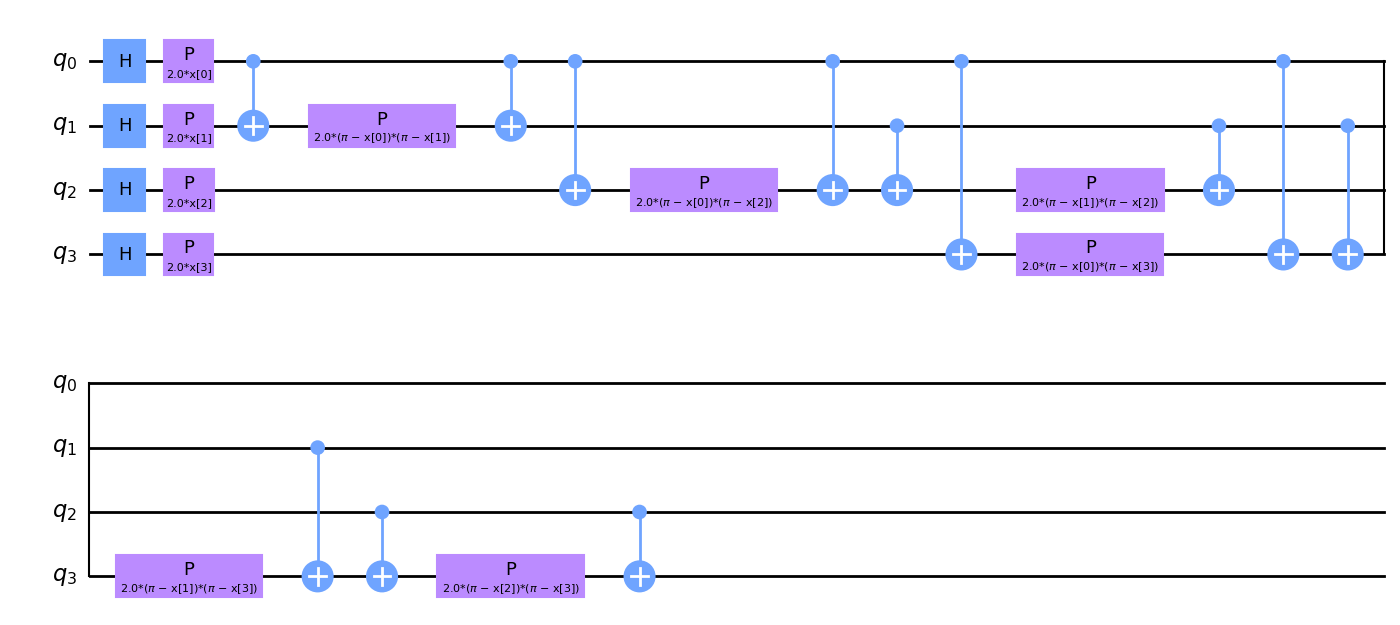

In [12]:
# Create feature map

num_iris_features = iris_features.shape[1]

iris_feature_map = ZZFeatureMap(feature_dimension=num_iris_features, reps=1)
iris_feature_map.decompose().draw(output="mpl", fold=20)


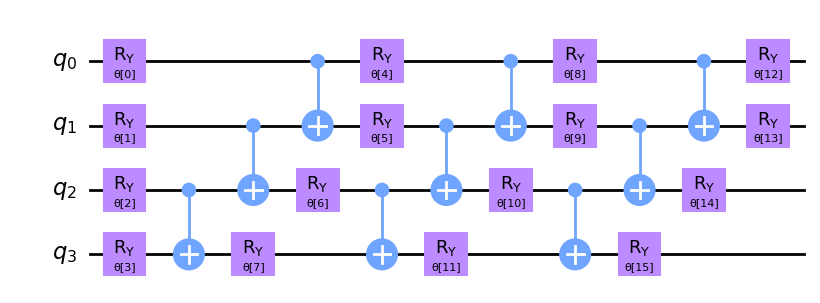

In [13]:
# Create ansatz
ansatz = RealAmplitudes(num_qubits=num_iris_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)


In [14]:
# Optimizer

optimizer = COBYLA(maxiter=100)
sampler = Sampler()


In [15]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals))
    , objective_func_vals)
    plt.show()


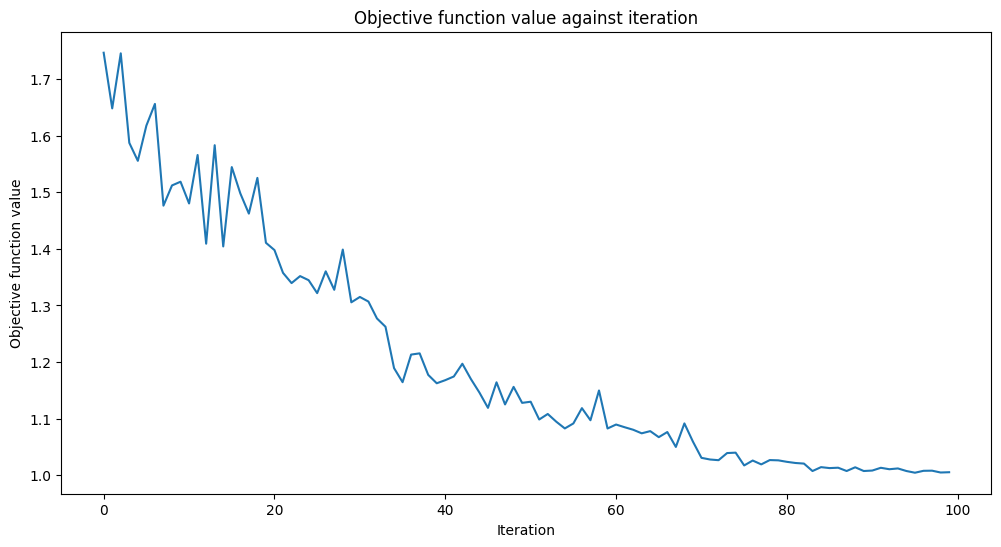

Training time: 36 seconds


In [16]:
# Create VQC
vqc = VQC(
    sampler=sampler,
    feature_map=iris_feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


# Wine classifier

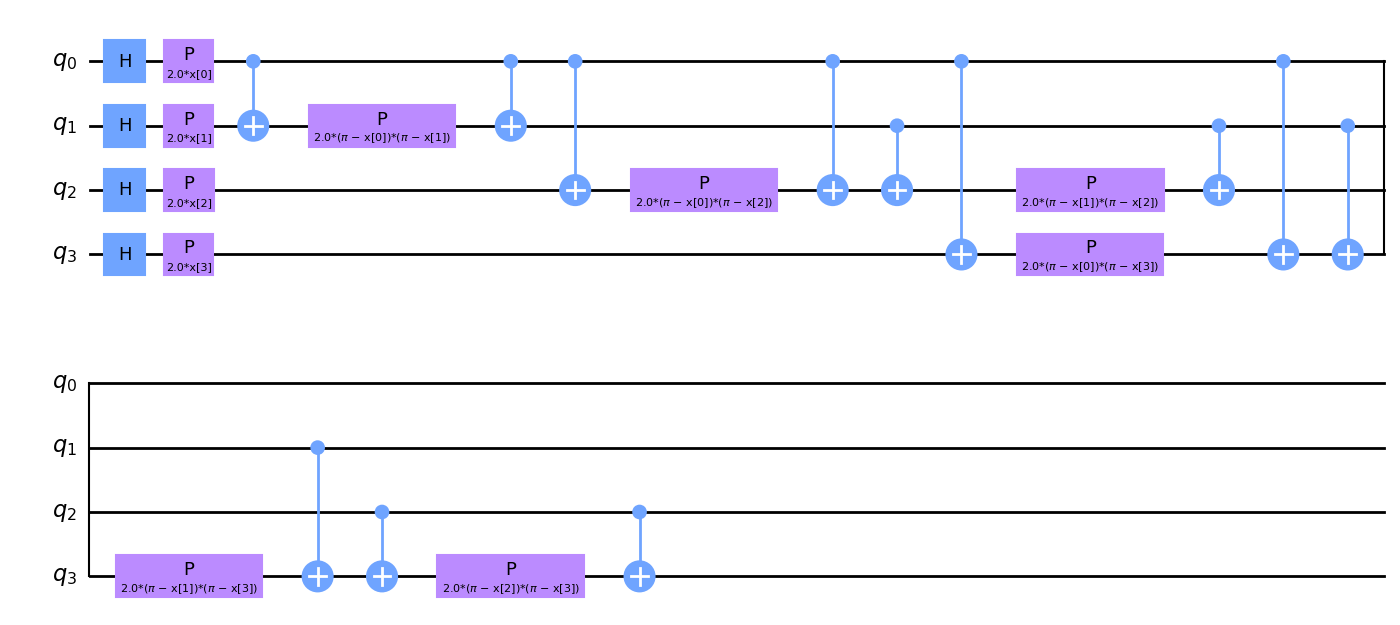

In [17]:
# create wine feature map

num_wine_features = wine_features.shape[1]

wine_feature_map = ZZFeatureMap(feature_dimension=num_wine_features, reps=1)
wine_feature_map.decompose().draw(output="mpl", fold=20)

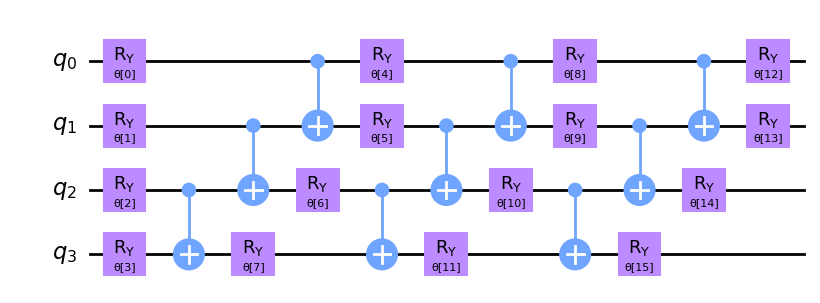

In [18]:
ansatz_wine = RealAmplitudes(num_qubits=num_wine_features, reps=3)
ansatz_wine.decompose().draw(output="mpl", fold=20)

In [19]:
# Optimizer

optimizer_wine = COBYLA(maxiter=100)
sampler_wine = Sampler()

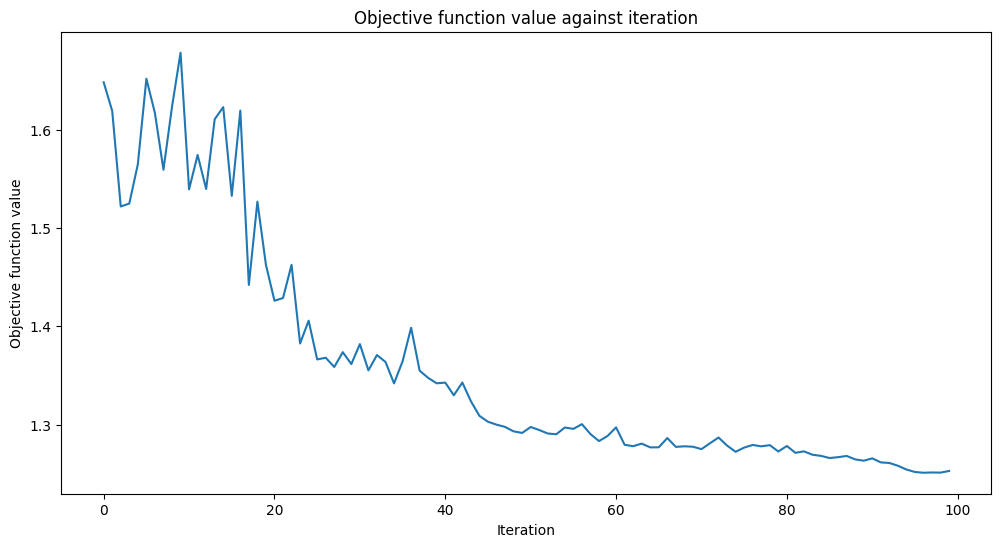

Training time: 41 seconds


In [20]:
# Create VQC

vqc_wine = VQC(
    sampler=sampler_wine,
    feature_map=wine_feature_map,
    ansatz=ansatz_wine,
    optimizer=optimizer_wine,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc_wine.fit(train_features_wine, train_labels_wine)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

# Breast Cancer Classifier

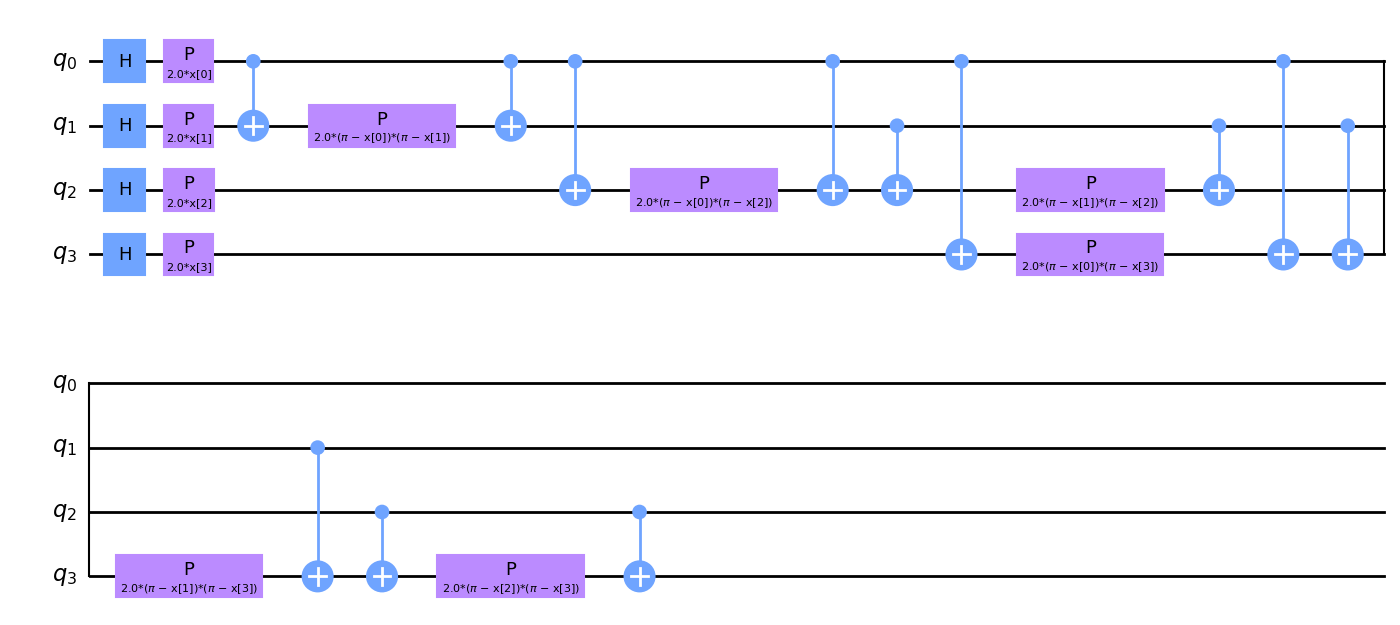

In [21]:
num_breast_cancer_features = breast_cancer_features.shape[1]

breast_cancer_feature_map = ZZFeatureMap(feature_dimension=num_breast_cancer_features, reps=1)
breast_cancer_feature_map.decompose().draw(output="mpl", fold=20)

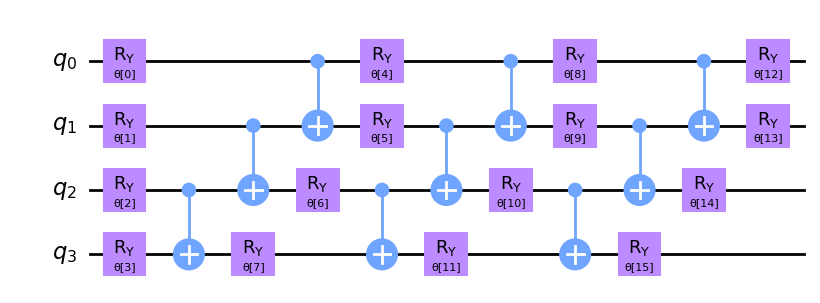

In [22]:
ansatz_breast_cancer = RealAmplitudes(num_qubits=num_breast_cancer_features, reps=3)
ansatz_breast_cancer.decompose().draw(output="mpl", fold=20)

In [23]:
# Optimizer

optimizer_breast_cancer = COBYLA(maxiter=100)
sampler_breast_cancer = Sampler()

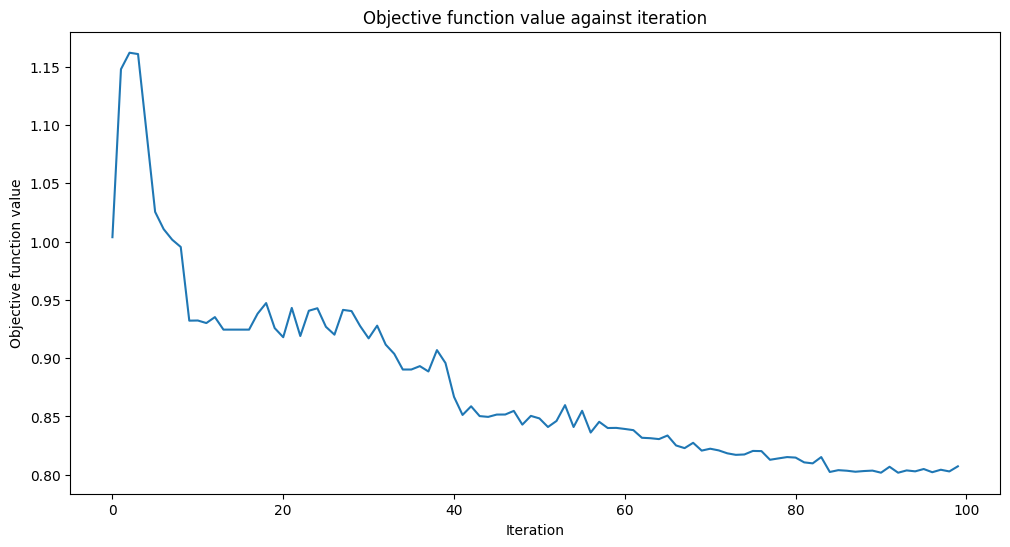

Training time: 112 seconds


In [24]:
# Create VQC

vqc_breast_cancer = VQC(
    sampler=sampler_breast_cancer,
    feature_map=breast_cancer_feature_map,
    ansatz=ansatz_breast_cancer,
    optimizer=optimizer_breast_cancer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc_breast_cancer.fit(train_features_breast_cancer, train_labels_breast_cancer)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

# Iris Results:

In [25]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")


Quantum VQC on the training dataset: 0.85
Quantum VQC on the test dataset:     0.87


# Wine Results:

In [26]:
train_score_q4_wine = vqc_wine.score(train_features_wine, train_labels_wine)
test_score_q4_wine = vqc_wine.score(test_features_wine, test_labels_wine)

print(f"Quantum VQC on the training dataset: {train_score_q4_wine:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4_wine:.2f}")

Quantum VQC on the training dataset: 0.65
Quantum VQC on the test dataset:     0.42


# Breast Cancer Results:

In [27]:
train_score_q4_breast_cancer = vqc_breast_cancer.score(train_features_breast_cancer, train_labels_breast_cancer)
test_score_q4_breast_cancer = vqc_breast_cancer.score(test_features_breast_cancer, test_labels_breast_cancer)

print(f"Quantum VQC on the training dataset: {train_score_q4_breast_cancer:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4_breast_cancer:.2f}")

Quantum VQC on the training dataset: 0.73
Quantum VQC on the test dataset:     0.72


# Measure other Results:

In [28]:
# Accuracy and resources for iris dataset
accuracy_iris = measure_accuracy(vqc, test_features, test_labels)
memory_iris, cpu_iris = measure_resources() 

# Accuracy and resources for wine dataset
accuracy_wine = measure_accuracy(vqc_wine, test_features_wine, test_labels_wine)
memory_wine, cpu_wine = measure_resources()

# Accuracy and resources for breast cancer dataset
accuracy_breast_cancer = measure_accuracy(vqc_breast_cancer, test_features_breast_cancer, test_labels_breast_cancer)
memory_breast_cancer, cpu_breast_cancer = measure_resources()


# Print results to a csv

In [29]:
# Create table of results

results = pd.DataFrame( 
    {
        "Dataset": ["Iris", "Wine", "Breast Cancer"],
        "Train Score": [train_score_q4, train_score_q4_wine, train_score_q4_breast_cancer],
        "Test Score": [test_score_q4, test_score_q4_wine, test_score_q4_breast_cancer],
        "Accuracy": [accuracy_iris, accuracy_wine, accuracy_breast_cancer],
        "Memory": [memory_iris, memory_wine, memory_breast_cancer],
        "CPU": [cpu_iris, cpu_wine, cpu_breast_cancer],

    }
)

# Print results to a csv file

results.to_csv("VQC_results.csv", index=False)

In [35]:
backend = FakeVigoV2()

qc_basis = transpile(vqc_breast_cancer.feature_map, backend=backend)

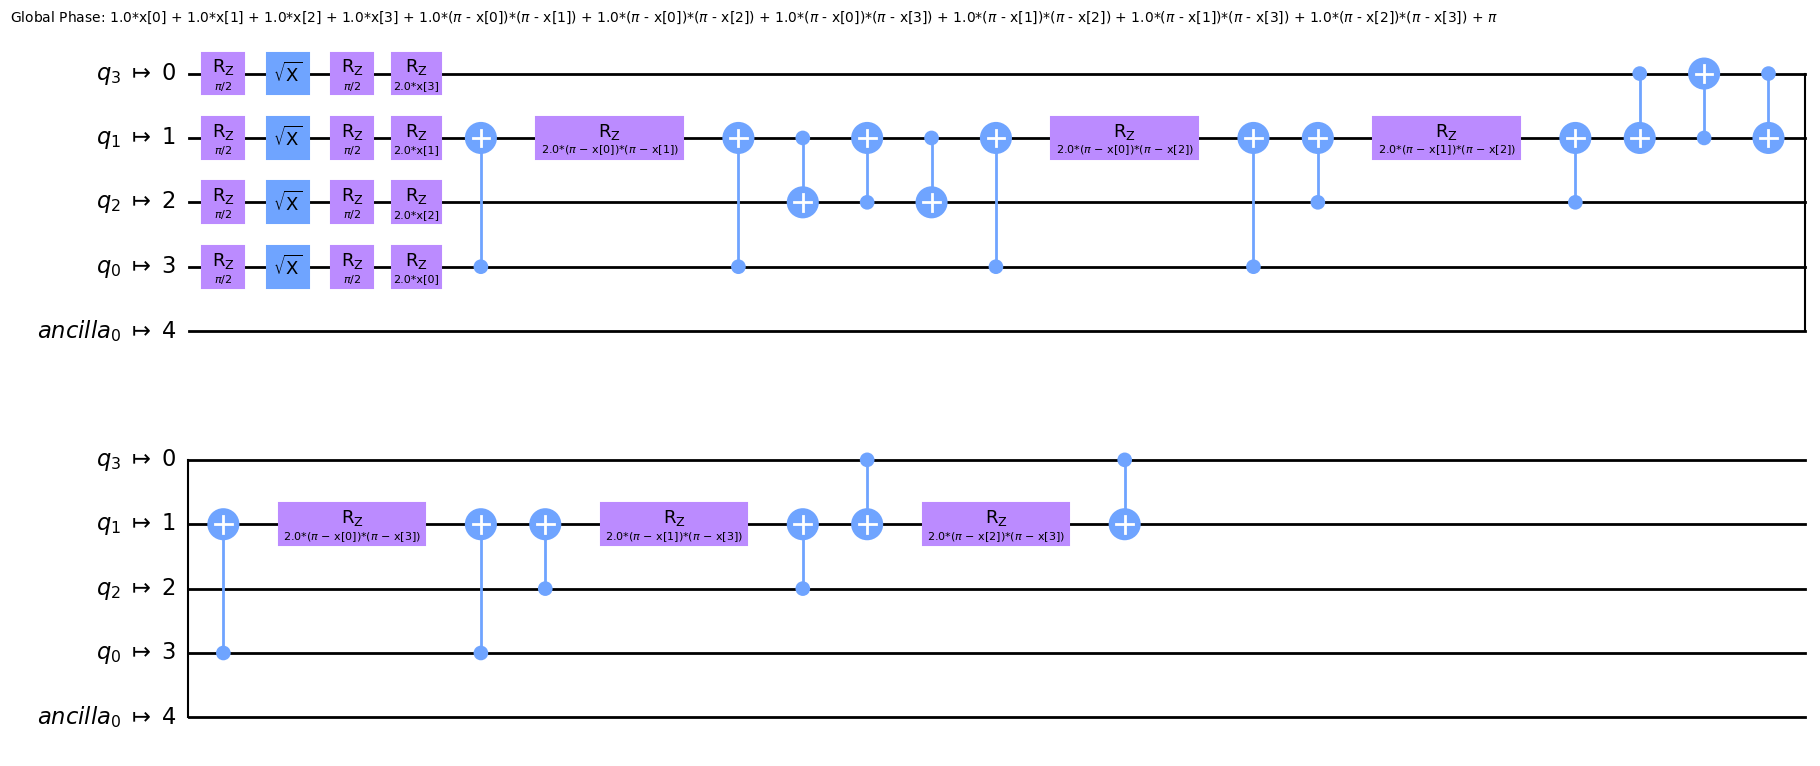

In [36]:
qc_basis.draw(output='mpl')
